In [14]:
from src.MO_DQN import MO_DQN
import mo_gymnasium as mo_gym
from src.gridsearch import gridsearch
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
import seaborn as sns

### Configure and run the experiments

### Data preprocessing

In [15]:
#load the data
df_complete = pd.read_csv("data/moma_circle_test_obs_spaces/moma_circle_test_obs_spaces_merged_summary.csv")
display(df_complete.info())
display(df_complete)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      1600 non-null   int64  
 1   repetition_number               1600 non-null   int64  
 2   weight_index                    1600 non-null   int64  
 3   weight_tuple                    1600 non-null   object 
 4   num_iterations                  1600 non-null   int64  
 5   vehicle_id                      1600 non-null   int64  
 6   normalised_speed_reward         1600 non-null   float64
 7   normalised_energy_reward        1600 non-null   float64
 8   raw_speed_reward                1600 non-null   float64
 9   raw_energy_reward               1600 non-null   float64
 10  env_config_id                   1600 non-null   int64  
 11  experiment_id                   1600 non-null   int64  
 12  replay_buffer_size              16

None

,Unnamed: 0,repetition_number,weight_index,weight_tuple,num_iterations,vehicle_id,normalised_speed_reward,normalised_energy_reward,raw_speed_reward,raw_energy_reward,env_config_id,experiment_id,replay_buffer_size,batch_size,reward_structure,use_multi_dqn,observation_space_name,increase_ego_reward_importance
0,0,0,0,"[0.0, 1.0]",38,0,0.051146,0.853941,1.943541,32.449776,0,0,10000,100,mean_reward,False,Kinematics,True
1,1,0,0,"[0.0, 1.0]",38,1,-0.921053,-0.850607,-35.000000,-32.323080,0,0,10000,100,mean_reward,False,Kinematics,True
2,2,1,0,"[0.0, 1.0]",6,0,0.324512,0.456269,1.947070,2.737615,0,0,10000,100,mean_reward,False,Kinematics,True
3,3,1,0,"[0.0, 1.0]",6,1,-0.555717,-0.398039,-3.334303,-2.388236,0,0,10000,100,mean_reward,False,Kinematics,True
4,4,2,0,"[0.0, 1.0]",19,0,-0.052632,0.796923,-1.000000,15.141528,0,0,10000,100,mean_reward,False,Kinematics,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,795,17,19,"[1.0, 0.0]",100,1,0.031852,0.983715,3.185188,98.371519,0,1,10000,100,mean_reward,False,OccupancyGrid,True
1596,796,18,19,"[1.0, 0.0]",100,0,0.044167,0.972140,4.416652,97.213962,0,1,10000,100,mean_reward,False,OccupancyGrid,True
1597,797,18,19,"[1.0, 0.0]",100,1,0.038295,0.984817,3.829496,98.481693,0,1,10000,100,mean_reward,False,OccupancyGrid,True
1598,798,19,19,"[1.0, 0.0]",100,0,0.030501,0.986557,3.050107,98.655729,0,1,10000,100,mean_reward,False,OccupancyGrid,True


In [16]:
#preprocess the dataframe
multi_index_list = ["experiment_id"]
value_list = ['normalised_speed_reward', 'normalised_energy_reward']
table = pd.pivot_table(df_complete, values=value_list, index=multi_index_list,
                        columns=['weight_index'], aggfunc="mean")
table = table.reset_index()
table['experiment_index'] = table.index
display(table)

experiment_id normalised_energy_reward                      \
weight_index                                      0         1         2   
0                        0                 0.445355  0.425925  0.357680   
1                        1                 0.783283  0.824214  0.593186   

                                                                          ...  \
weight_index         3         4         5         6         7         8  ...   
0             0.396424  0.460884  0.406264  0.452884  0.502953  0.565102  ...   
1             0.836328  0.883909  0.892322  0.965582  0.817335  0.674058  ...   

             normalised_speed_reward                                          \
weight_index                      11        12        13        14        15   
0                          -0.145955 -0.174305 -0.207358 -0.159429 -0.159389   
1                          -0.037863 -0.181319 -0.007125 -0.073068 -0.107020   

                                                     experiment_index  
weight_index        16        17        18        19                   
0            -0.138641 -0.268719 -0.133730 -0.163113                0  
1            -0.067345 -0.071933  0.019059  0.030544                1  

[2 rows x 42 columns]

<Axes: xlabel='normalised_speed_reward', ylabel='normalised_energy_reward'>

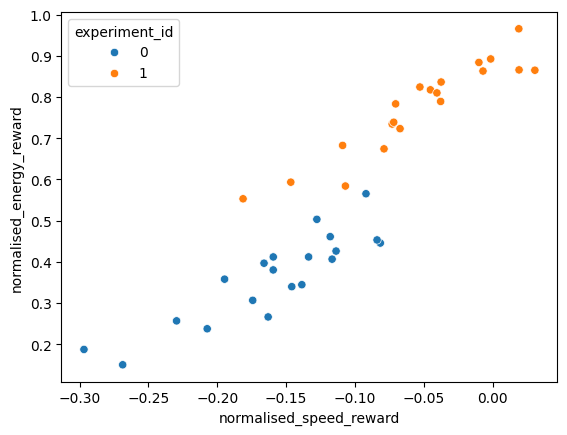

In [17]:
grouped_df = df_complete.groupby(["experiment_id", "weight_index"])[["normalised_speed_reward", "normalised_energy_reward"]].mean()
sns.scatterplot(grouped_df, x="normalised_speed_reward", y="normalised_energy_reward", hue="experiment_id")

<Axes: xlabel='weight_index', ylabel='num_iterations'>

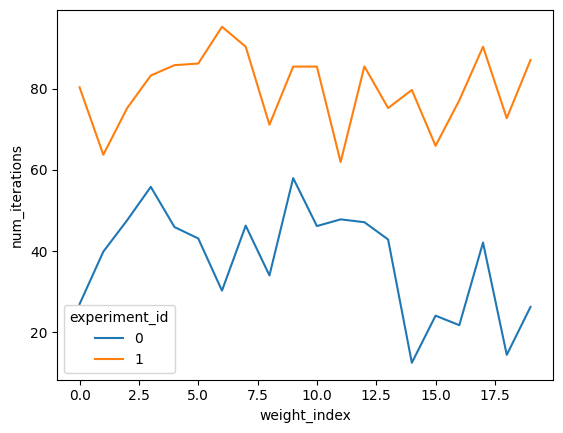

In [18]:
grouped_df = df_complete.groupby(["experiment_id", "weight_index"])[["num_iterations"]].mean()
sns.lineplot(grouped_df, x="weight_index", y="num_iterations", hue="experiment_id")

In [19]:
nds = NonDominatedSorting()
value_columns = ["normalised_speed_reward", "normalised_energy_reward"]
#add pareto information
grouped_df["pareto"] = False
experiment_indices = grouped_df["experiment"].unique()
for index in experiment_indices:
    #get data of a specific experiment
    data = grouped_df[grouped_df["experiment"] == index]
    #compute the indices containing non-dominated points
    pareto_indices = nds.do(-1 * data[value_columns], only_non_dominated_front=True)
    #set pareto flag to True at the corresponding indices of the entire dataframe
    grouped_df.loc[(grouped_df["experiment"] == index) & (data["weight_index"].isin(pareto_indices)),"pareto"] = True

KeyError: 'experiment'

In [20]:
#plot all points
import seaborn as sns
ax = sns.scatterplot(data=grouped_df, x='normalised_speed_reward', y='normalised_energy_reward', hue="experiment", style="env_config_id")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ValueError: Could not interpret value `normalised_speed_reward` for `x`. An entry with this name does not appear in `data`.

In [21]:
#plot only non-dominated points
ax = sns.scatterplot(data=grouped_df[grouped_df["pareto"]==True], x='normalised_speed_reward', y='normalised_energy_reward', hue="experiment")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ValueError: Could not interpret value `normalised_speed_reward` for `x`. An entry with this name does not appear in `data`.

In [22]:
# num iterations
multi_index_list = ["env_config_id", 'network_hidden_sizes', "weight_index"]
value_list = ["num_iterations"]
grouped_df = df_complete.groupby(multi_index_list)[value_list].mean()
index = grouped_df.index
grouped_df = grouped_df.reset_index()
grouped_df.set_index(index, inplace=True)
multi_index_list.remove("weight_index")
grouped_df["experiment"] = grouped_df[multi_index_list].apply(tuple, axis=1)

KeyError: 'network_hidden_sizes'

In [23]:
ax = sns.lineplot(grouped_df, x="weight_index", y="num_iterations", hue="experiment", style="env_config_id")
sns.move_legend(ax, "center left")

df_complete.groupby(["env_config_id", "weight_index"])["num_iterations"].mean()
print()

ValueError: Could not interpret value `experiment` for `hue`. An entry with this name does not appear in `data`.

experiment_id 0 --> collision reward -1
experiment_id 1 --> collision reward 0
--> collision reward of -1 works better.

In [24]:
# loss logger
import seaborn as sns
df_loss = pd.read_csv("data/network_sizes_kinematics_with_lane/experiment_merged_loss.csv")
display(df_loss.info())
display(df_loss)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 10 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   Unnamed: 0                        1200000 non-null  int64  
 1   iteration                         1188012 non-null  float64
 2   loss                              1188012 non-null  float64
 3   env_config_id                     1200000 non-null  int64  
 4   experiment_id                     1200000 non-null  int64  
 5   gamma                             1200000 non-null  float64
 6   replay_buffer_size                1200000 non-null  int64  
 7   use_reward_normalisation_wrapper  1200000 non-null  bool   
 8   use_default_reward_normalisation  1200000 non-null  bool   
 9   network_hidden_sizes              1200000 non-null  object 
dtypes: bool(2), float64(3), int64(4), object(1)
memory usage: 75.5+ MB


None

,Unnamed: 0,iteration,loss,env_config_id,experiment_id,gamma,replay_buffer_size,use_reward_normalisation_wrapper,use_default_reward_normalisation,network_hidden_sizes
0,0,NaN,NaN,0,0,0.9,1000,False,True,"[128, 128]"
1,1,NaN,NaN,0,0,0.9,1000,False,True,"[128, 128]"
2,2,NaN,NaN,0,0,0.9,1000,False,True,"[128, 128]"
3,3,NaN,NaN,0,0,0.9,1000,False,True,"[128, 128]"
4,4,NaN,NaN,0,0,0.9,1000,False,True,"[128, 128]"
...,...,...,...,...,...,...,...,...,...,...
1199995,99995,99995.0,0.031234,2,3,0.9,1000,False,True,"[256, 256, 256]"
1199996,99996,99996.0,0.090288,2,3,0.9,1000,False,True,"[256, 256, 256]"
1199997,99997,99997.0,0.078996,2,3,0.9,1000,False,True,"[256, 256, 256]"
1199998,99998,99998.0,0.103990,2,3,0.9,1000,False,True,"[256, 256, 256]"


<Axes: xlabel='iteration', ylabel='loss'>

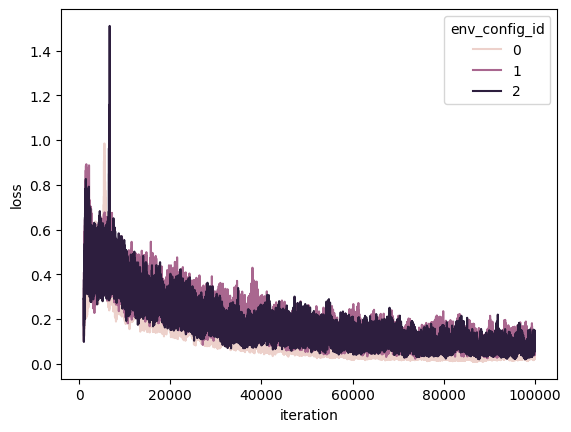

In [25]:
grouped_loss = df_loss.groupby(["iteration","env_config_id"])["loss"].mean()
grouped_loss = grouped_loss.reset_index()
sns.lineplot(grouped_loss, x="iteration", y="loss", hue="env_config_id")

In [26]:
print(grouped_loss)

        iteration  env_config_id      loss
0           999.0              0  0.275066
1           999.0              1  0.287709
2           999.0              2  0.290482
3          1000.0              0  0.275302
4          1000.0              1  0.283717
...           ...            ...       ...
296998    99998.0              1  0.088037
296999    99998.0              2  0.098804
297000    99999.0              0  0.026802
297001    99999.0              1  0.052374
297002    99999.0              2  0.068694

[297003 rows x 3 columns]
